#XGBoost Implementation

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math

In [103]:
google = pd.read_csv('../src/Data/google_clean.csv')

###Splitting into Train and Test Data

In [141]:
x = google.drop(['App', 'Last Updated', 'Rating'], axis = 1)
y = google['Rating']

In [142]:
from sklearn.model_selection import train_test_split

In [143]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 123)

In [144]:
x_train_vals = x_train.values
y_train_vals = y_train.values

x_test_vals = x_test.values
y_test_vals = y_test.values

Due to the large amount of time it would require to run a true grid search cross validation on the XGBoost model all at once, I will be tuning the XGBoost model a few parameters at a time. Below is the function that I will use to tune the XGBoost model using the GridSearchCV function from the scikit-learn library

In [118]:
def xgb_tune(param, train_data, predictors, n = 5):
    
    xgb_search = GridSearchCV(xgb.XGBRegressor(random_state = 123), param, cv = n, return_train_score = True)
    xgb_search.fit(train_data, predictors)
    
    #return xgb_search.cv_results_
    return xgb_search.best_params_

###Tuning learning rate and n_estimators (number of trees)

In [151]:
param = {'n_estimators' : [50, 75, 100, 125, 150, 175, 200],
        'learning_rate' : [0.05, 0.1, 0.2, 0.3]}

In [152]:
xgb_tune(param, x_train_vals, y_train_vals)

{'learning_rate': 0.2, 'n_estimators': 125}

###Tuning max_depth and min_child_weight

In [153]:
param = {'n_estimators' : [125],
        'learning_rate' : [0.2],
        'max_depth' : [2, 4, 6, 8, 10],
        'min_child_weight' : [1, 2, 3, 4, 5]}

In [154]:
xgb_tune(param, x_train_vals, y_train_vals)

{'learning_rate': 0.2,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 125}

###Tuning gamma

In [155]:
param = {'n_estimators' : [125],
        'learning_rate' : [0.2],
        'max_depth' : [2],
        'min_child_weight' : [1], 
        'gamma' : [i/10 for i in range(0,6)]}

In [156]:
xgb_tune(param, x_train_vals, y_train_vals)

{'gamma': 0.0,
 'learning_rate': 0.2,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 125}

###Tuning subsample and colsample_bytree

In [157]:
param = {'n_estimators' : [125],
        'learning_rate' : [0.2],
        'max_depth' : [2],
        'min_child_weight' : [1], 
        'gamma' : [0],
        'subsample' : [i/10 for i in range(3,10)],
        'colsample_bytree' : [i/10 for i in range(3,10)]}

In [158]:
xgb_tune(param, x_train_vals, y_train_vals)

{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 125,
 'subsample': 0.9}

###Tuning Regularization parameters (reg_alpha and reg_lambda)

In [159]:
param = {'n_estimators' : [125],
        'learning_rate' : [0.2],
        'max_depth' : [2],
        'min_child_weight' : [1], 
        'gamma' : [0],
        'subsample' : [0.9],
        'colsample_bytree' : [0.9],
        'reg_alpha' : [0.01, 0.1, 1, 10],
        'reg_lambda' : [0.01, 0.1, 1, 10]
        }

In [160]:
xgb_tune(param, x_train_vals, y_train_vals)

{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 125,
 'reg_alpha': 1,
 'reg_lambda': 0.01,
 'subsample': 0.9}

####Tuning alpha and lambda again to figures much closer to what we came up with

In [163]:
param = {'n_estimators' : [125],
        'learning_rate' : [0.2],
        'max_depth' : [2],
        'min_child_weight' : [1], 
        'gamma' : [0],
        'subsample' : [0.8],
        'colsample_bytree' : [0.9],
        'reg_alpha' : [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3],
        'reg_lambda' : [0, 0.01, 0.05, 0.075, 0.1]
        }

In [164]:
xgb_tune(param, x_train_vals, y_train_vals)

{'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 125,
 'reg_alpha': 0.7,
 'reg_lambda': 0.05,
 'subsample': 0.8}

In [165]:
xgb_model = xgb.XGBRegressor(learning_rate = 0.2,
                            max_depth = 2,
                            min_child_weight = 1,
                            n_estimators = 125,
                            gamma = 0,
                            reg_alpha = 0.7,
                            reg_lambda = 0.05,
                            subsample = 0.8, 
                            colsample_bytree = 0.9)

xgb_model.fit(x_train, y_train, eval_metric = 'rmse')
train_predict = xgb_model.predict(x_test)



print(('\nBaseline Testing RMSE: {}').format(np.array(y_test_vals).std()))
print(('\nModel Testing RMSE: {}').format(math.sqrt(metrics.mean_squared_error(y_test_vals, train_predict))))


Baseline Testing RMSE: 0.48353604080758344

Model Testing RMSE: 0.4505027374568078


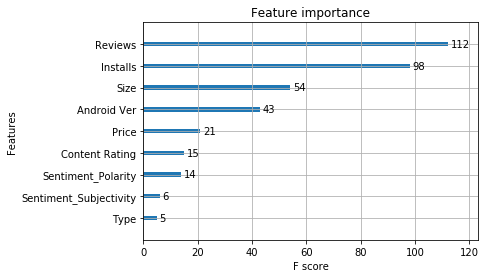

In [166]:
xgb.plot_importance(xgb_model)
plt.show()

In [ ]:
final_params = {'colsample_bytree': 0.9,
                'gamma': 0,
                'eta': 0.1,
                'max_depth': 8,
                'min_child_weight': 2,
                'alpha': 0.03,
                'lambda': 0.8,
                'subsample': 0.6}

cv_model = xgb.cv(final_params, , num_boost_rounds = 100, nfold = 3)